In [1]:
%load_ext autoreload

%autoreload complete

# Duffing Chain Decoupling Example NPAD

In [2]:
import cupy as np
import matplotlib.pyplot as plt
import numpy
import qutip as qt

from qcheff.duffing.duffing_chain_utils import (
    create_uneven_Duffing_Chain,
    duffing_chain_num_ham,
)

rng = np.random.default_rng()

import matplotlib as mpl
from matplotlib.colors import LogNorm

from qcheff.gpu.npad import npad_decouple_sim, npad_diagonalize


def plot_matelm_mag(H: np.ndarray, scale="log"):
    fig, ax = plt.subplots(1, 1, layout="constrained")
    absH = np.abs(H)
    P1 = ax.imshow(
        absH.get(), cmap="binary", norm=LogNorm(vmin=1e-10) if scale == "log" else None
    )
    ax.set(xticks=[], yticks=[])
    plt.colorbar(P1, ax=ax)


def plot_offdiag_mag(H: np.ndarray, scale="log"):
    plot_matelm_mag(H - np.diag(np.diagonal(H)), scale=scale)


mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
mpl.rcParams["text.usetex"] = False
mpl.rcParams["legend.fontsize"] = 20
mpl.rcParams["axes.titlesize"] = 20

In [3]:
global_chain_size = 5
global_ntrunc = 3
system_dims = [global_ntrunc] * global_chain_size
example_chain = create_uneven_Duffing_Chain(
    chain_size=global_chain_size, ntrunc=global_ntrunc
)

In [4]:
chain_full_ham = np.asarray(duffing_chain_num_ham(example_chain)[:])
two_ex_subspace = list(qt.state_number_enumerate(system_dims, excitations=2))
two_ex_idx = [qt.state_number_index(system_dims, state) for state in two_ex_subspace]
H2 = chain_full_ham[two_ex_idx, two_ex_idx]

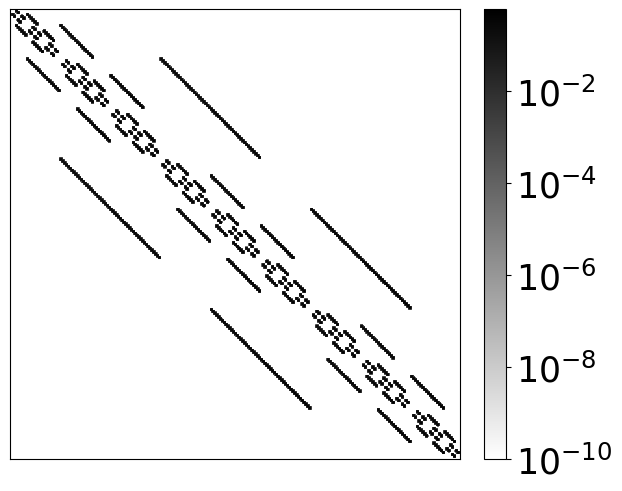

In [5]:
plot_offdiag_mag(chain_full_ham)

# Large scale NPAD example for benchmarking

We want to block diagonalize a chain of duffing oscillators into a chain of qubits.

There are 3^5 = 243 levels in this chain of size 5. We want to turn this into a 2^5=32 level 5 qubit chain. First we need to partition levels we care about and those we don't.

In [6]:
all_levels = list(qt.state_number_enumerate(system_dims))
qubit_chain_levels = [label for label in all_levels if max(label) <= 1]
other_levels = [label for label in all_levels if label not in qubit_chain_levels]

Now that we have identified labels for each set of levels, we need to find their indices in the matrix (so that we can either reorganize it, or just find the list of couplings).

In [7]:
chain_idx = np.asarray(
    [qt.state_number_index(system_dims, label) for label in qubit_chain_levels]
)
other_idx = np.asarray(
    [qt.state_number_index(system_dims, label) for label in other_levels]
)

Now, we can find the couping matrix. This will not be square.

In [8]:
len(chain_idx)

32

In [9]:
chain_idx

array([  0,   1,   3,   4,   9,  10,  12,  13,  27,  28,  30,  31,  36,
        37,  39,  40,  81,  82,  84,  85,  90,  91,  93,  94, 108, 109,
       111, 112, 117, 118, 120, 121])

In [10]:
coupling_offdiags = chain_full_ham[np.ix_(chain_idx, other_idx)]
# plot_matelm_mag(coupling_offdiags)

First we find out where the nonzero couplings are, then we can find these indices

We now need to rotate away these couplings. (or ensure that the norm of the offdiagonal coupling matrix goes down.)

In [11]:
# plot_matelm_mag(npad_diagonalize(H=chain_full_ham[:]))

### NPAD decoupling

## Optimizations

Now we need to see how much faster we can make this

In [12]:
np.get_array_module(chain_full_ham)

<module 'cupy' from '/home/abhis/miniforge3/envs/cupy-env/lib/python3.11/site-packages/cupy/__init__.py'>

  0%|          | 0/2000 [00:00<?, ?it/s]

NameError: name 'ic' is not defined

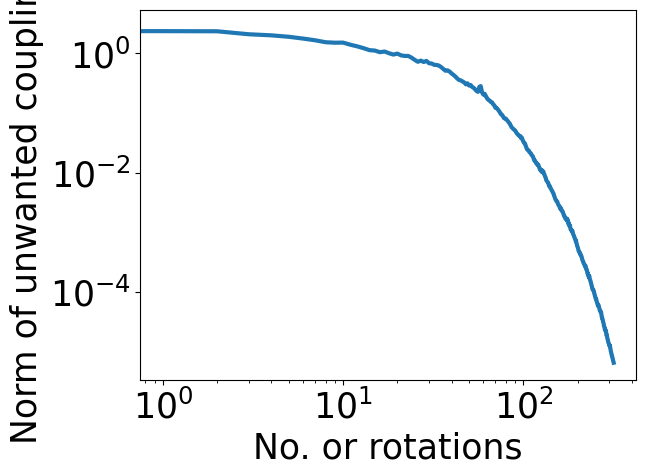

In [13]:
decH, normlist = npad_decouple_sim(
    chain_full_ham,
    incl_idx=chain_idx,
    excl_idx=other_idx,
    eps=1e-9,
    ret_norm=True,
    max_rots=2000,
    batch_size=20,
    debug=True,
)

normlist = np.asarray(normlist).get()
plt.loglog(normlist)
plt.xlabel("No. or rotations")
plt.ylabel("Norm of unwanted couplings")
print(len(normlist), np.min(normlist))

In [ ]:
full_eigs = np.sort(np.linalg.eigvalsh(chain_full_ham[:]))
subspace_eigs = np.sort(np.linalg.eigvalsh(decH[np.ix_(chain_idx, chain_idx)]))
numpy.all(
    [numpy.isclose(eigval.get(), full_eigs.get()).any() for eigval in subspace_eigs]
)

True

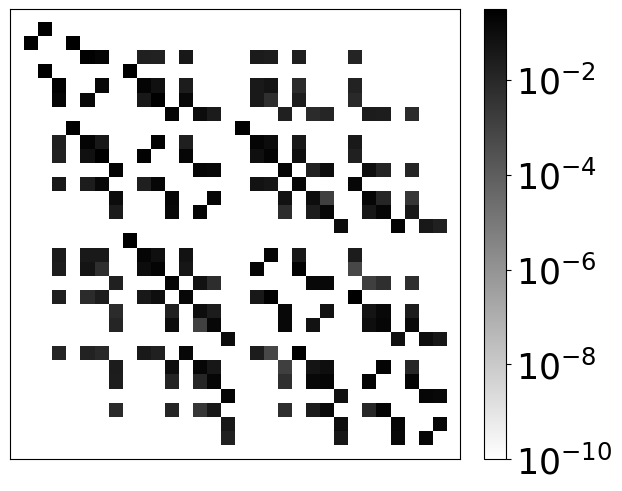

In [ ]:
chainH = np.asarray(decH[np.ix_(chain_idx, chain_idx)])
# ic(qt.Qobj(chainH).isherm)
plot_offdiag_mag(chainH)